<a href="https://colab.research.google.com/github/SejinHan25/crack_segmentation/blob/main/crack_size.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Install necessary packages & Check datasets 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -qq '/content/drive/MyDrive/Colab Notebooks/crack_segmentation/Datasets/Datasets.zip'

In [5]:
!pip install segmentation-models-pytorch
!pip install pytorch-lightning
!pip install torchtext
!pip install adamp
!pip install wandb
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 4.6 MB/s 
     |████████████████████████████████| 58 kB 5.8 MB/s 
     |████████████████████████████████| 376 kB 52.1 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=7ecba6f5c265ab4cb1b2670c5872dcb5d9bf052764cb2aaea5bfb0a162a74243
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=bbc2309a6bf6ddd5030c4dc28178d321808d16b5243c71668ffa23a7d73395c2
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |███████

In [6]:
import os 
import cv2
import torch
import torchvision
import PIL
import wandb
import natsort

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torch.optim.lr_scheduler as lr_scheduler

from adamp import AdamP
from torchmetrics.functional import jaccard_index, accuracy, f1_score, precision, recall
from glob import glob
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split
from ipywidgets import interact
from torchvision.transforms.functional import to_pil_image
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from pytorch_lightning.loggers import WandbLogger

pl.seed_everything(42)

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


42

In [8]:
image_test_dir = "/content/Test/images/"
mask_test_dir = "/content/Test/masks/"

images_test_paths = glob(image_test_dir + "*.jpg")
masks_test_paths = glob(mask_test_dir + "*.png")

images_test_paths = natsort.natsorted(images_test_paths)
masks_test_paths = natsort.natsorted(masks_test_paths)
df_test = pd.DataFrame({'images': images_test_paths, 'masks': masks_test_paths})
df_test.head(5)

,images,masks
0,/content/Test/images/20160222_080933.jpg,/content/Test/masks/20160222_080933_mask.png
1,/content/Test/images/20160222_081839.jpg,/content/Test/masks/20160222_081839_mask.png
2,/content/Test/images/20160222_114759.jpg,/content/Test/masks/20160222_114759_mask.png
3,/content/Test/images/20160222_115305.jpg,/content/Test/masks/20160222_115305_mask.png
4,/content/Test/images/20160222_163940.jpg,/content/Test/masks/20160222_163940_mask.png


In [9]:
@interact(index=(0, len(df_test)-1))
def show_images(index=0):
    image = cv2.imread(df_test.iloc[index].images)
    mask = cv2.imread(df_test.iloc[index].masks)

    plt.figure(figsize=(12,10))
    plt.subplot(121)
    plt.title("image")
    plt.imshow(image)
    plt.subplot(122)
    plt.title("mask")
    plt.imshow(mask)
    plt.tight_layout()

interactive(children=(IntSlider(value=0, description='index', max=114), Output()), _dom_classes=('widget-inter…

In [10]:
image_path = df_test.iloc[3].images
mask_path = df_test.iloc[3].masks

## 2. Skeletonization

In [11]:
def zhang_suen_skeleton(img):
    # use zhang_suen algorithm
    skel = cv2.ximgproc.thinning(img)
    
    return skel

def check_connectivity(block_img):
    block_img[1][1] = 0
    (rows, cols) = np.nonzero(block_img)
    rows = sorted(rows)
    cols = sorted(cols)

    # condition 1
    for i in range(len(rows)-1):
        if rows[i+1] - rows[i] > 1:
            return False
    for j in range(len(cols)-1):
        if cols[j+1] - cols[j] > 1:
            return False
    
    # condition 2: check 4 corners
    if block_img[0][0] > 0:
        if block_img[0][1] == 0 and block_img[1][0] == 0:
            return False
    if block_img[2][0] > 0:
        if block_img[2][1] == 0 and block_img[1][0] == 0:
            return False
    if block_img[2][2] > 0:
        if block_img[2][1] == 0 and block_img[1][2] == 0:
            return False
    if block_img[0][2] > 0:
        if block_img[0][1] == 0 and block_img[1][2] == 0:
            return False

    return True

def single_pixelated(img):
    (rows, cols) = np.nonzero(img)
    result = img.copy()
    removed_pixels = []
    for (r, c) in zip(rows, cols):
        if (r, c) not in removed_pixels:
            block_img = result[r-1: r+2, c-1: c+2].copy()
            if np.sum(block_img) >=3*255:
                # if check_connectivity(block_img):
                #     result[r][c] = 0
                removed_pixels.append((r, c))
    return result

if __name__ == "__main__":
    img = cv2.imread(mask_path,0)
    skel = zhang_suen_skeleton(img)

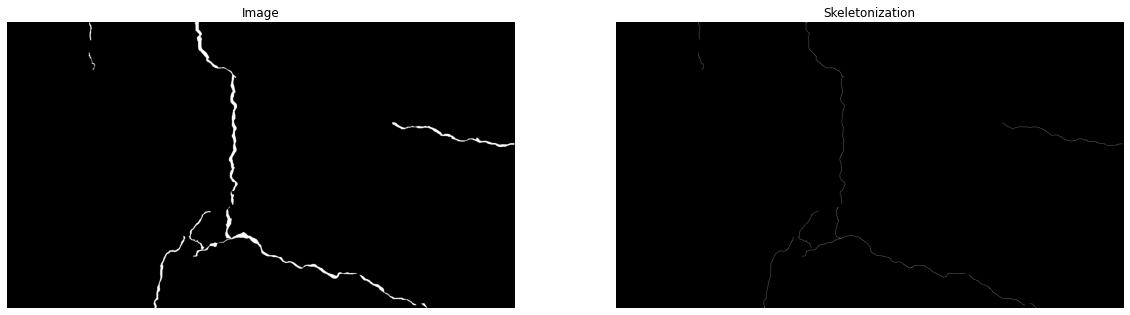

True

In [12]:
img = cv2.imread(mask_path)

fig, ax = plt.subplots(1, 2, figsize=(20,20))

ax[0].set_title("Image")
ax[0].imshow(img)
ax[0].axis('off')

ax[1].set_title("Skeletonization")
ax[1].imshow(skel, cmap='gray')
ax[1].axis('off')

plt.show()

cv2.imwrite('skel.png', skel)

In [13]:
white_pixels_skel=[]
for x in range(skel.shape[0]):
    for y in range(skel.shape[1]):
      if skel[x][y] == 255:
        white_pixels_skel.append((x,y))

In [14]:
len(white_pixels_skel)

4236

## 3. Canny Edge Detection

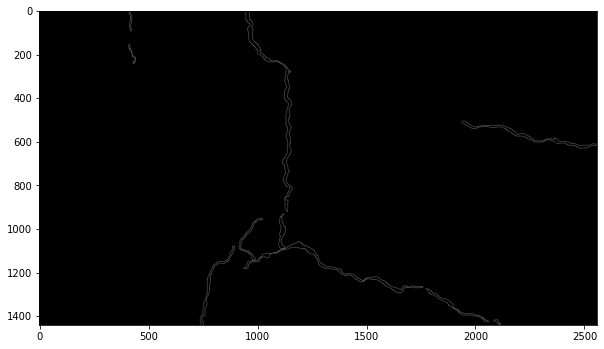

In [15]:
image = cv2.imread(mask_path, 0)
canny = cv2.Canny(image, 100, 150)

fig = plt.figure(figsize=(10,6))
plt.imshow(canny, cmap='gray')

In [16]:
white_pixels_canny=[]
for x in range(canny.shape[0]):
    for y in range(canny.shape[1]):
      if canny[x][y] == 255:
        white_pixels_canny.append((x,y))

In [17]:
len(white_pixels_canny)

8797

## 4. Crack width

In [18]:
import math

In [19]:
def calc_distance(a, b):
    y_distance = (a[0] - b[0]) ** 2
    x_distance = (a[1] - b[1]) ** 2
    return  x_distance + y_distance

In [20]:
pixel_pairs = []
distance = []

for skel_idx in range(len(white_pixels_skel)):
    
    min_distance = math.inf
    temp_pixel_pairs = None
    distance_pairs = None

    for canny_idx in range(len(white_pixels_canny)):
        temp_distance = calc_distance(white_pixels_skel[skel_idx], white_pixels_canny[canny_idx])
        # print(temp_distance)
        if  temp_distance < min_distance:
            temp_pixel_pairs = [white_pixels_skel[skel_idx], white_pixels_canny[canny_idx]]
            temp_pixel_pairs_distance = [white_pixels_skel[skel_idx], white_pixels_canny[canny_idx], math.sqrt(temp_distance)]
            min_distance = temp_distance
    pixel_pairs.append(temp_pixel_pairs)
    distance.append(temp_pixel_pairs_distance)

In [21]:
crack_width = []
for a,b,c in distance:
    crack_width.append(int(c*2))
    
crack_width = pd.Series(crack_width)

In [22]:
crack_width.describe()

count    4236.000000
mean        8.245987
std         4.093641
min         0.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        22.000000
dtype: float64

In [23]:
crack_width.max()

22

In [24]:
max_d = -math.inf
count = 0
max_crack_width_idx = 0
for a,b,c in distance:
    count += 1
    # print(f"{count}번째 픽셀 균열 폭: {int(c*2)}")
    if c > max_d:
        max_d = c
        max_crack_width_idx = count - 1 
print(f"최대 균열 폭: {int(max_d * 2)}")

최대 균열 폭: 22


In [25]:
distance[max_crack_width_idx][0]

(1074, 1192)

In [26]:
y1 = distance[max_crack_width_idx][0][0]
x1 = distance[max_crack_width_idx][0][1]
y2 = distance[max_crack_width_idx][1][0]
x2 = distance[max_crack_width_idx][1][1]

x3 = (2 * x1) - x2
y3 = (2 * y1) - y2

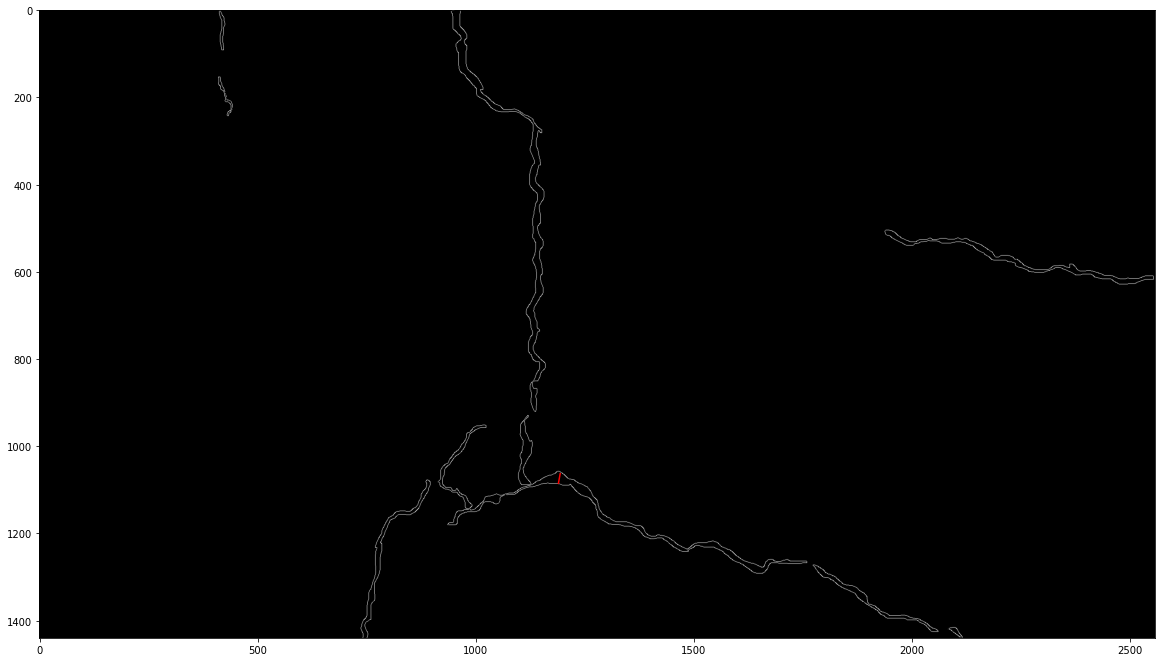

In [30]:
plt.figure(figsize=(20,20))

plt.imshow(canny, cmap='gray')
# plt.axis('off')

plt.plot([x3,x2],[y3,y2],color="red")

plt.show()

### 4-1. Visualization of crack width

In [31]:
orig_img = cv2.imread(mask_path)
viz_image = np.zeros(orig_img.shape, dtype=np.uint8)

In [32]:
for skel_idx, canny_idx in pixel_pairs:
    viz_image[skel_idx] = np.array([0, 0, 255])
    viz_image[canny_idx] = np.array([0, 255, 0])
    # break
viz_image[distance[max_crack_width_idx][0]] = np.array([255, 0, 0])
viz_image[distance[max_crack_width_idx][1]] = np.array([255, 0, 0])

True

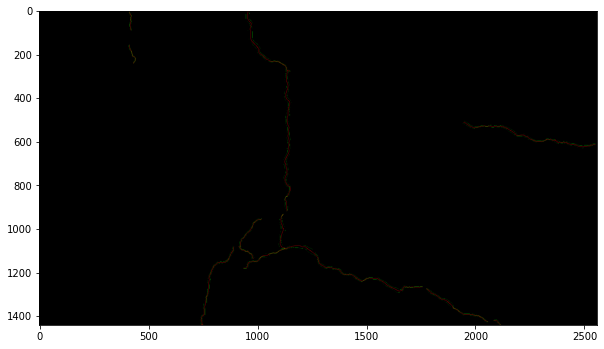

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(viz_image[: ,: , ::-1])

cv2.imwrite('result.png', viz_image)

## 5. Contour
contour 내부 crack의 각 픽셀 수 구하기

In [34]:
# import the necessary packages
import matplotlib.pyplot as plt
from scipy.spatial import distance as dist
# from imutils import perspective
# from imutils import contours
import numpy as np
import argparse
# import imutils
import cv2

In [35]:
img = cv2.imread(mask_path, 0)
# Threshold the image
kernel = np.ones((3, 3), np.uint8)

img = dilation = cv2.dilate(img, kernel, iterations=20)
ret,img = cv2.threshold(img, 127, 255, 0)

# Step 1: Create an empty skeleton
size = np.size(img)
skel = np.zeros(img.shape, np.uint8)

# Get a Cross Shaped Kernel
element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))



# Repeat steps 2-4
while True:
    #Step 2: Open the image
    open = cv2.morphologyEx(img, cv2.MORPH_OPEN, element)
    #Step 3: Substract open from the original image
    temp = cv2.subtract(img, open)
    #Step 4: Erode the original image and refine the skeleton
    eroded = cv2.erode(img, element)
    skel = cv2.bitwise_or(skel,temp)
    img = eroded.copy()
    # Step 5: If there are no white pixels left ie.. the image has been completely eroded, quit the loop
    if cv2.countNonZero(img)==0:
        break

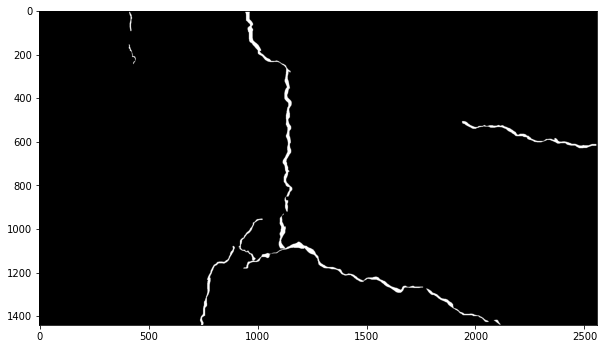

In [36]:
image = cv2.imread(mask_path, 0)
ret, thresh = cv2.threshold(image, 160, 255, cv2.THRESH_BINARY)
plt.figure(figsize=(10,10))
plt.imshow(thresh, cmap='gray')

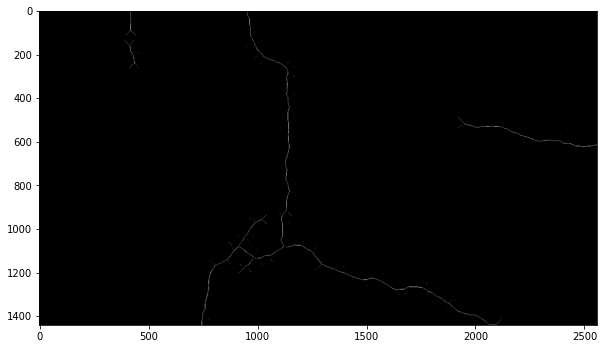

In [37]:
thresh = cv2.bitwise_or(skel, thresh)
plt.figure(figsize=(10,10))
plt.imshow(skel, cmap='gray')

In [38]:
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  
contours = list(filter(lambda x: cv2.contourArea(x) > 10, contours)) 

In [39]:
CLASS_COLOR = np.array([[0, 0, 0], [192, 0, 128],[0, 128, 192],[0, 128, 64],[128, 0, 0],
        [64, 0, 128],[64, 0, 192],[192, 128, 64],[192, 192, 128],[64, 64, 128],
        [128, 0, 192],[255, 0, 0],[0, 255, 0],[0, 0, 255],[128, 128, 128],
        [153, 0, 51], [102, 255, 153] , [255, 51, 153], [102, 204, 255],[0, 102, 51],
        [255, 153, 204]], np.uint8)

In [40]:
# count the number of pixels inside cracks
for idx in range(len(contours)):
    print(f'{idx} area : {cv2.contourArea(contours[idx])}')
    print('-'*30)

0 area : 218.0
------------------------------
1 area : 5493.5
------------------------------
2 area : 447.5
------------------------------
3 area : 32223.0
------------------------------
4 area : 435.5
------------------------------


### 5-1. Visualization of bounding box for each contour

In [41]:
image = cv2.imread(mask_path, 0)

viz_box = image.copy() # np.zeros((*(image.shape), 3), dtype=np.uint8)
viz_box = cv2.cvtColor(viz_box, cv2.COLOR_GRAY2BGR)

for idx in range(len(contours)):
    x, y, w, h = cv2.boundingRect(contours[idx])
    viz_box = cv2.rectangle(viz_box, (x,y), (x+w, y+h), CLASS_COLOR[idx+1].tolist(), 5)
    viz_box = cv2.drawContours(viz_box, contours, idx ,CLASS_COLOR[idx+1].tolist(), 5)

    cv2.putText(img=viz_box, text=str(idx), org=(x, y+40), fontFace=1, fontScale=4, thickness=3, color=(255, 255, 255))

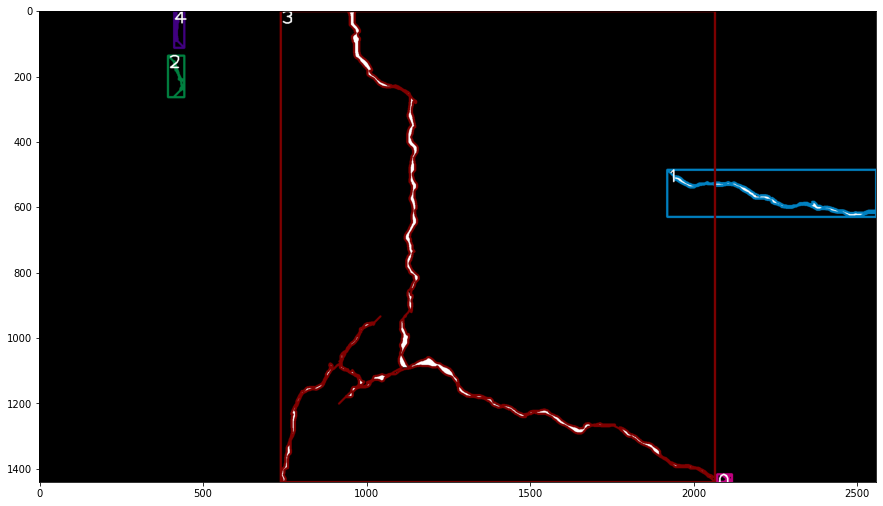

In [42]:
fig = plt.figure(figsize=(15,15))
plt.imshow(viz_box)

In [43]:
cv2.imwrite('viz_box.png', viz_box)

True